# Skewness Removal in a Nutshell - hands on tutorial

--ver 0.1, created by Dr. Jie Tao

Real-world data can be messy. Even some learning datasets contain attributes that need severe modifications before they can be used to do predictive modeling.

## Key Assumptions for Data in Predictive Models

Let’s take a linear regression model for example. You probably know this already, but the model makes a good amount of assumptions for the data you provide, such as:

1. **Linearity**: assumes that the relationship between predictors and target variable is linear
2. **No noise**: eg. that there are no outliers in the data
3. **No collinearity**: if you have highly correlated predictors, it’s most likely your model will overfit
4. **Normal distribution**: more reliable predictions are made if the predictors and the target variable are normally distributed
5. **Scale**: it’s a distance-based algorithm, so preditors should be scaled — like with standard scaler.

You can see these assumptions correspond to the __suggested tasks__ in your competition 1, but today we gonna focus in #4.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

## Skewness Defined

1. No Skew - Normal Distribution: Mean = Median = Mode
<img src = "https://miro.medium.com/max/720/1*V3wUT_rqJm6ly5vYgk64Dg.webp"/>

2. Left/Negatively-skewed: Mode > Median > Mean
<img src = "https://miro.medium.com/max/720/1*oWh214Dm0mbDdoGAlVw_gg.webp"/>

3. Right/positively skewed: Mean > Median > Mode
<img src = "https://miro.medium.com/max/720/1*oDRXZugvjxbDlxqJEwmJzA.webp"/>

__PRO TIP__: more data (particularly counting data) are left skewed.

## How to (mathematically) detect skewness?

$$ skewness = \frac{3 \times (mean - median)}{stdev} $$

skewness in the range of [-3, 3] is acceptable, of course the lower the better.

But in real world, we typically use a different measure.

Let's use a dataset to demonstrate.

In [ ]:
boston_data = load_boston()

## features
X = boston_data['data']
## target
y = boston_data['target']
## feature names
cols = boston_data['feature_names']

print(X.shape, y.shape)
print(cols)

(506, 13) (506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [ ]:
## look at data
all_data = pd.DataFrame(X, columns=cols)
all_data['price'] = y
all_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Let's look at the actual distribution of one feature.

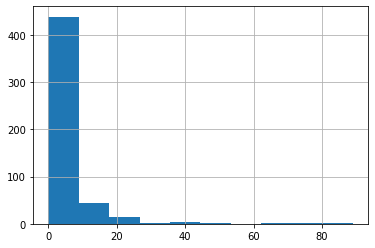

In [ ]:
all_data['CRIM'].hist();

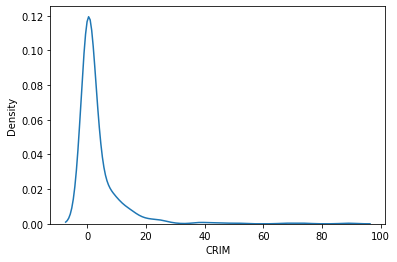

In [ ]:
sns.kdeplot(all_data['CRIM']);

Let's look at the skewness of one feature.

In [ ]:
all_data['CRIM'].kurtosis()

37.13050912952203

In [ ]:
all_data['CRIM'].skew() ## stricter to the skewness measure

5.223148798243851

For the `.skew()` method, if:
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical;
- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
-If the skewness is less than -1 or greater than 1, the data are highly skewed



## How to handle skewness?

First you have to decide what kind of skewness the data has (left/right), then choose proper handling technique.

Since left skewed data is more popular, let's start with that.

### Log Transform

We can simply do it using `numpy`. Just notice that to use the `log()` function, you data has to be __positive__.

In [ ]:
## let's test the positivity
all_data['CRIM'].min() > 0

True

In [ ]:
crim_log = np.log(all_data['CRIM'])
crim_log.skew()

0.4059344988496048

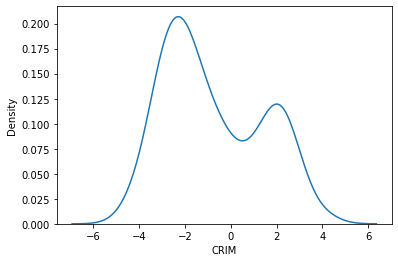

In [ ]:
sns.kdeplot(crim_log);

If the data is right skewed, instead of log, you should consider using __exponential__.

## Square Root Transform

The square root sometimes works great and sometimes isn’t the best suitable option.

You can apply a square root transformation via `numpy`, by calling the `sqrt()` function.

Just notice that to use the `sqrt()` function, you data has to be __positive__.

In [ ]:
crim_sqrt = np.sqrt(all_data['CRIM'])
crim_sqrt.skew()

2.024382103123676

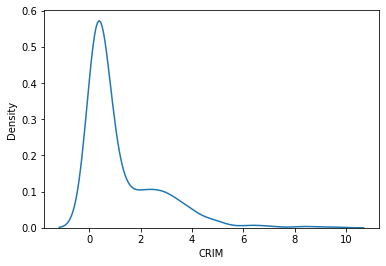

In [ ]:
sns.kdeplot(crim_sqrt);

In this case, if your data is right skewed, you can use squared.

Cube roots/cube also works similarly.

### Box-Cox Transform

If you use Box-Cox transform, your data must be __positive__. So let's first test if our feature fits the requirement.

Also note Box-Cox is not as picky whether your data is left or right skewed.

In [ ]:
### first element is the transformed data, second is the parameter controlling it
### in this case we just need the first
crim_boxcox = pd.Series(stats.boxcox(all_data['CRIM'])[0])
### the boxcox() function transfer data to numpy arrays, in order to use the .skew()
### method, we have to make it back to pandas
crim_boxcox.skew()

0.09364917268984103

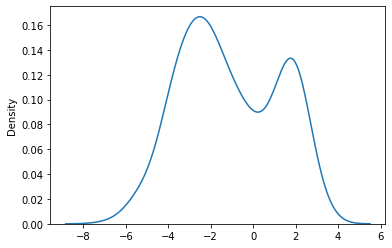

In [ ]:
sns.kdeplot(crim_boxcox);

### What if my data is not all positive?

All you need to do is to transform them (move them to the positive side).

In [ ]:
fake_data = pd.DataFrame([0-np.random.lognormal(0, 1, 1000) for i in range(3)]).T
fake_data.columns = ["x1", "x2", "x3"]
fake_data.head()

,x1,x2,x3
0,-2.450006,-0.557374,-1.667239
1,-7.875016,-0.509627,-2.746366
2,-0.669680,-1.298996,-5.181159
3,-0.768186,-1.960561,-0.380384
4,-0.540496,-2.476801,-0.360221


In [ ]:
fake_data.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,1000.0,-1.752983,2.834960,-47.103849,-1.999441,-1.040323,-0.527060,-0.052356
x2,1000.0,-1.650634,2.406531,-34.264748,-1.919215,-0.958973,-0.480076,-0.032981
x3,1000.0,-1.555971,1.670150,-13.749393,-2.028381,-1.028461,-0.535275,-0.043459


In [ ]:
stats.boxcox(fake_data['x1']) ### ERROR: Data must be positive.

ValueError: ignored

In [ ]:
all_pos_data = []
for _, col in fake_data.iteritems():
  # print(col, col.min())
  all_pos_data.append(col + abs(col.min()) + 1)

all_pos_df = pd.concat(all_pos_data, axis=1)
all_pos_df.columns = fake_data.columns
all_pos_df.head()
  

,x1,x2,x3
0,45.653843,34.707374,13.082153
1,40.228832,34.755121,12.003027
2,47.434169,33.965752,9.568234
3,47.335662,33.304186,14.369008
4,47.563353,32.787947,14.389171


__THINK__: why i did not just use the `abs()` function on all the data?

In [ ]:
all_pos_df.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,1000.0,46.350866,2.834960,1.0,46.104408,47.063526,47.576789,48.051492
x2,1000.0,33.614114,2.406531,1.0,33.345532,34.305775,34.784671,35.231766
x3,1000.0,13.193422,1.670150,1.0,12.721011,13.720932,14.214117,14.705934


In [ ]:
all_pos_df.x1.skew()

-8.933803654707324

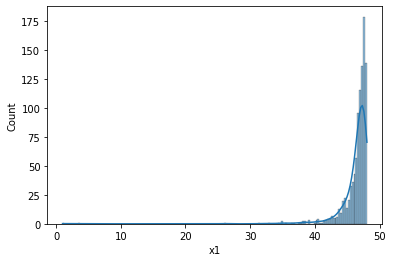

In [ ]:
sns.histplot(all_pos_df.x1, kde=True);

In [ ]:
x1_boxcox = pd.Series(stats.boxcox(all_pos_df.x1)[0])
x1_boxcox.skew()

-0.771316905409437

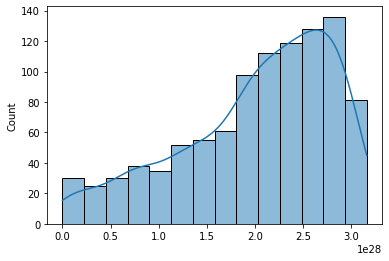

In [ ]:
sns.histplot(x1_boxcox, kde=True);

### What if I want to handle a dataframe (multiple features) at the same time?

In [ ]:
## if you are using log
log_df = np.log(all_pos_df)

In [ ]:
## using box-cox
boxcox_data = []
for _, col in all_pos_df.iteritems():
  boxcox_data.append(pd.Series(stats.boxcox(col)[0]))

boxcox_df = pd.concat(boxcox_data, axis=1)
boxcox_df.head()

,0,1,2
0,1.279411e+28,4.750300e+21,1.932851e+06
1,1.365120e+27,4.848158e+21,1.119053e+06
2,2.517078e+28,3.448156e+21,2.653495e+05
3,2.426199e+28,2.575632e+21,3.506468e+06
4,2.641135e+28,2.042926e+21,3.537821e+06


In [ ]:
boxcox_df.skew()

0   -0.771317
1   -0.702624
2   -0.547196
dtype: float64

## Now what's the way to relief more assumptions?

e.g., how about not requiring data to be positive, that would be nice.

In this case, we can use the Yeo-Johnson transformation.

In [ ]:
### similar to box-cox, we just need the transformed data, not the parameter
x1_yeojohnson, _ = stats.yeojohnson(fake_data.x1)
x1_yeojohnson = pd.Series(x1_yeojohnson)

Now we can compare them side by side.

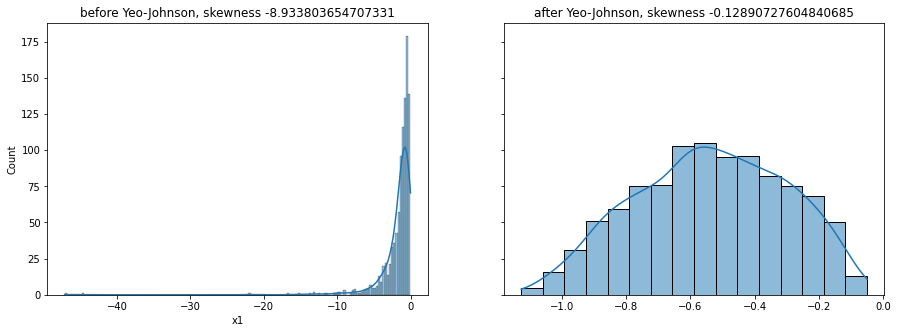

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15, 5))
sns.histplot(fake_data.x1, kde=True, ax=ax1)
ax1.title.set_text("before Yeo-Johnson, skewness {}".format(fake_data.x1.skew()))
sns.histplot(x1_yeojohnson, kde=True, ax=ax2)
ax2.title.set_text("after Yeo-Johnson, skewness {}".format(x1_yeojohnson.skew()));

Try a different feature:

In [ ]:
crim_yj = pd.Series(stats.boxcox(all_data['CRIM'])[0])
crim_yj.skew()

0.09364917268984103

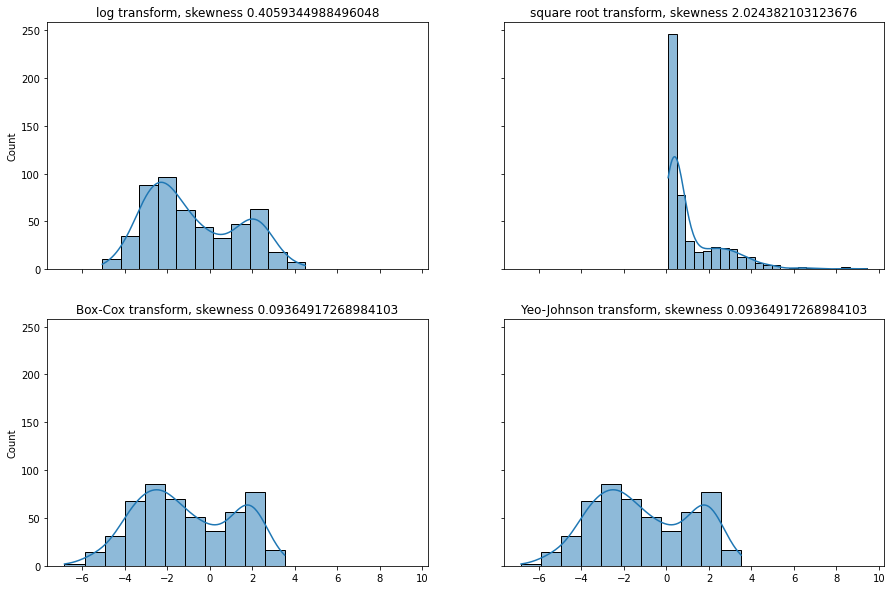

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=2, sharex=True, sharey=True, figsize=(15, 10))
sns.histplot(crim_log, kde=True, ax=axs[0,0])
axs[0,0].title.set_text("log transform, skewness {}".format(crim_log.skew()))
sns.histplot(crim_sqrt, kde=True, ax=axs[0,1])
axs[0,1].title.set_text("square root transform, skewness {}".format(crim_sqrt.skew()))
sns.histplot(crim_boxcox, kde=True, ax=axs[1,0])
axs[1,0].title.set_text("Box-Cox transform, skewness {}".format(crim_boxcox.skew()))
sns.histplot(crim_yj, kde=True, ax=axs[1,1])
axs[1,1].title.set_text("Yeo-Johnson transform, skewness {}".format(crim_yj.skew()));

You can see if the data is all positive, Box-Cox and Yeo-Johnson work the same. But Box-cox is __cheaper__.

## Recommendations/tips

1. As you can see, Yeo-Johnson is very powerful, so that might be your first choice - just note your might want to convert the results back to `pandas`;
2. You can stack different normalization/skewness removal techniques together if one doesn't work well;
3. There is no __best__ technique, keep trying is the only way.